In [1]:
import torch
from torch.nn import MSELoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import pickle
import wandb

from torch.utils.data import Dataset, DataLoader, Subset, random_split
import tonic

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

class CCMKDataset(Dataset):
    def __init__(self, spikes_tensor, labels_tensor, nchannels=None, target_label=2, seed=None, device=None):
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.spikes_tensor = spikes_tensor.to(device)
        self.labels_tensor = labels_tensor.to(device)

        if nchannels is not None:
            self.spikes_tensor = self.spikes_tensor[:, nchannels, :]
        
        # Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]
        
        # Convert the target label (2) to 1
        self.labels_tensor[self.labels_tensor == target_label] = 1
        
        # Downsampling: Match the number of label 0 samples to the number of label 1 samples
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]
        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        #CPU
        # selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False), device=self.device)
        # selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False), device=self.device)

        # GPU
        selected_label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))[:num_samples]].to(self.device)
        selected_label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))[:num_samples]].to(self.device)


        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int().cpu())}")

    def __len__(self):
        return len(self.labels_tensor)
    
    def __getitem__(self, idx):
        spike_data = self.spikes_tensor[idx]
        label = self.labels_tensor[idx]
        return spike_data, label

c:\Users\Angela\anaconda3\envs\capstone_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_loader = torch.load('saved_loaders_bs32/train_loader.pth')
val_loader = torch.load('saved_loaders_bs32/val_loader.pth')
test_loader = torch.load('saved_loaders_bs32/test_loader.pth')

C:\Users\Angela\AppData\Local\Temp\ipykernel_93188\3645305366.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load('saved_loaders_bs32/train_loader.

In [3]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

n_channels = 16  
n_classes = 1   
n_time = 101
dt = 10e-3     

model = SynNet(
    output="vmem",
    n_channels=n_channels,                        
    n_classes=n_classes,
    dt=dt,                           
    size_hidden_layers=[48, 24, 48],        
    time_constants_per_layer=[8, 10, 12],
    tau_syn_base=0.02,  
    tau_mem=0.02,
    tau_syn_out=0.02
)

print(model)

c:\Users\Angela\anaconda3\envs\capstone_gpu\lib\site-packages\rockpool\nn\networks\__init__.py:15: UserWarning: This module needs to be ported to teh v2 API.
  warnings.warn(f"{err}")
c:\Users\Angela\anaconda3\envs\capstone_gpu\lib\site-packages\rockpool\nn\networks\__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")


SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 48)
        LIFTorch '1_LIFTorch' with shape (48, 48)
        TimeStepDropout '2_TimeStepDropout' with shape (48,)
        LinearTorch '3_LinearTorch' with shape (48, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 48)
        LIFTorch '7_LIFTorch' with shape (48, 48)
        TimeStepDropout '8_TimeStepDropout' with shape (48,)
        LinearTorch '9_LinearTorch' with shape (48, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


In [4]:
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "drawn_wood_training_comparing_potentials.ipynb"

In [6]:
import pickle
import numpy as np
from sklearn.metrics import precision_score, recall_score
import wandb
from torch.nn import MSELoss
from torch.optim import Adam
from tqdm import trange
import matplotlib.pyplot as plt
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking


seed = 42
learning_rate = 1e-3
size_hidden_layers=[48, 24, 48]        
time_constants_per_layer=[8, 10, 12]

device = torch.device("cpu")  

# Target class potential configurations
potential_configs = [
    {"target_class_potential": 1, "non_target_class_potential": -1, "model_name": "drawn-wood-42-1"},
    {"target_class_potential": 3, "non_target_class_potential": -3, "model_name": "drawn-wood-42-3"}
]

for potential_config in potential_configs:
    target_class_potential = potential_config["target_class_potential"]
    non_target_class_potential = potential_config["non_target_class_potential"]
    model_name = potential_config["model_name"]
    
    wandb.init(
        project="drawn_wood_42_training",  
        config={
            "learning_rate": learning_rate,
            "size_hidden_layers": size_hidden_layers,
            "time_constants_per_layer": time_constants_per_layer,
            "architecture": "SNN",
            "dataset": "Meerkat calls",
            "epochs": 200,
            "target_class_potential": target_class_potential,
            "non_target_class_potential": non_target_class_potential,
            "packages": ["torch", "numpy", "pickle", "wandb"]
        }
    )

    config = wandb.config

    torch.manual_seed(seed)

    # Initialize model 
    model = SynNet(
        output="vmem",
        n_channels=16,                        
        n_classes=1,
        dt=10e-3,                           
        size_hidden_layers=size_hidden_layers,        
        time_constants_per_layer=time_constants_per_layer,
        tau_syn_base=0.02,  
        tau_mem=0.02,
        tau_syn_out=0.02,
    ).to(device)

    # Hyperparameters
    n_epochs = config.epochs
    optimizer = Adam(model.parameters().astorch(), lr=learning_rate)
    loss_fun = MSELoss()

    # Store losses, internal states, and metrics
    train_losses = []
    val_losses = []
    membrane_potentials = []
    spike_outputs = []
    synaptic_currents = []

    # Training phase
    for epoch in trange(n_epochs):
        model.train()
        epoch_loss = 0
        predictions_train = []
        ground_truths_train = []
        
        for batch in train_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs, _, _ = model(inputs, record=True)
            outputs_vmem = outputs[:, -1, :].to(device)  # Last time step along the time axis

            # Target membrane potential values
            target_membrane_potential = torch.zeros_like(outputs_vmem).to(device)
            target_membrane_potential[labels == 1] = target_class_potential  # Target class
            target_membrane_potential[labels == 0] = non_target_class_potential  # Non-target class

            # Compute loss
            loss = loss_fun(outputs_vmem, target_membrane_potential)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Only collect predictions and ground truths during the final epoch
            if epoch == n_epochs - 1:
                predictions_train.append(outputs_vmem.detach().cpu().numpy())
                ground_truths_train.append(labels.cpu().numpy())

            # Access internal layer membrane potentials, spikes, synaptic currents
            for lyr_name in model.lif_names:
                lyr = model.seq[lyr_name]

                v_mem = lyr.vmem.detach().cpu().numpy()  
                spikes = lyr.spikes.detach().cpu().numpy()  
                i_syn = lyr.isyn.detach().cpu().numpy()  

                membrane_potentials.append(v_mem)
                spike_outputs.append(spikes)
                synaptic_currents.append(i_syn)

        train_losses.append(epoch_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0
        predictions_val = []
        ground_truths_val = []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.permute(0, 2, 1).to(device)
                labels = labels.to(device)
                outputs, _, _ = model(inputs, record=True)
                outputs_vmem = outputs[:, -1, :].to(device)

                # Target membrane potential values
                target_membrane_potential = torch.zeros_like(outputs_vmem).to(device)
                target_membrane_potential[labels == 1] = target_class_potential
                target_membrane_potential[labels == 0] = non_target_class_potential

                # Compute validation loss
                loss = loss_fun(outputs_vmem, target_membrane_potential)
                val_loss += loss.item()

                # Only collect predictions and ground truths during the final epoch
                if epoch == n_epochs - 1:
                    predictions_val.append(outputs_vmem.detach().cpu().numpy())
                    ground_truths_val.append(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))

        # Log loss for the current epoch
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_losses[-1],
            "val_loss": val_losses[-1]
        })
        print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    # Calculate metrics for training and validation at the final epoch
    if predictions_train and ground_truths_train:
        predicted_labels_train = np.where(np.concatenate(predictions_train) > 0, 1, 0).flatten()
        ground_truths_train_flat = np.concatenate(ground_truths_train).flatten()
        train_accuracy = (predicted_labels_train == ground_truths_train_flat).mean() * 100
        train_precision = precision_score(ground_truths_train_flat, predicted_labels_train)
        train_recall = recall_score(ground_truths_train_flat, predicted_labels_train)

    if predictions_val and ground_truths_val:
        predicted_labels_val = np.where(np.concatenate(predictions_val) > 0, 1, 0).flatten()
        ground_truths_val_flat = np.concatenate(ground_truths_val).flatten()
        val_accuracy = (predicted_labels_val == ground_truths_val_flat).mean() * 100
        val_precision = precision_score(ground_truths_val_flat, predicted_labels_val)
        val_recall = recall_score(ground_truths_val_flat, predicted_labels_val)

    # Log metrics from the final epoch to wandb
    wandb.log({
        "final_train_accuracy": train_accuracy,
        "final_train_precision": train_precision,
        "final_train_recall": train_recall,
        "final_val_accuracy": val_accuracy,
        "final_val_precision": val_precision,
        "final_val_recall": val_recall
    })

    print(f"Final Training Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}")
    print(f"Final Validation Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}")

    # Save results and model state for this configuration
    results_folder = "drawn_wood_results"
    os.makedirs(results_folder, exist_ok=True)

    output_filename = f"{results_folder}/{model_name}.pkl"
    with open(output_filename, 'wb') as f:
        pickle.dump({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracy': train_accuracy,
            'train_precision': train_precision,
            'train_recall': train_recall,
            'val_accuracy': val_accuracy,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'membrane_potentials': membrane_potentials,
            'spike_outputs': spike_outputs,
            'synaptic_currents': synaptic_currents,
            'predictions_train': predictions_train,
            'ground_truths_train': ground_truths_train,
            'predictions_val': predictions_val,
            'ground_truths_val': ground_truths_val
        }, f)

    # Save model state
    model_state_filename = f"{results_folder}/{model_name}.pt"
    torch.save(model.state_dict(), model_state_filename)

    # Finish the wandb run for this configuration
    wandb.finish()

  0%|          | 1/200 [00:15<52:40, 15.88s/it]

Epoch 1/200, Training Loss: 3.295859440317694, Validation Loss: 0.9302844405174255


  1%|          | 2/200 [00:31<52:48, 16.00s/it]

Epoch 2/200, Training Loss: 0.9412934847597806, Validation Loss: 0.7614762229578835


  2%|▏         | 3/200 [00:47<52:29, 15.99s/it]

Epoch 3/200, Training Loss: 0.8901744237485921, Validation Loss: 0.6802837039743151


  2%|▏         | 4/200 [01:03<51:44, 15.84s/it]

Epoch 4/200, Training Loss: 0.7874173010295292, Validation Loss: 0.5614560927663531


  2%|▎         | 5/200 [01:18<50:01, 15.39s/it]

Epoch 5/200, Training Loss: 0.7763246851709654, Validation Loss: 0.6598587398018155


  3%|▎         | 6/200 [01:32<48:51, 15.11s/it]

Epoch 6/200, Training Loss: 0.7299245326024182, Validation Loss: 0.6439295794282641


  4%|▎         | 7/200 [01:48<49:06, 15.26s/it]

Epoch 7/200, Training Loss: 0.7236642123393293, Validation Loss: 0.7292817894901548


  4%|▍         | 8/200 [02:03<49:02, 15.33s/it]

Epoch 8/200, Training Loss: 0.7429310780651165, Validation Loss: 0.6908407488039562


  4%|▍         | 9/200 [02:19<48:48, 15.33s/it]

Epoch 9/200, Training Loss: 0.6442583400123524, Validation Loss: 0.7081597064222608


  5%|▌         | 10/200 [02:34<48:34, 15.34s/it]

Epoch 10/200, Training Loss: 0.6400810277686929, Validation Loss: 0.6190975457429886


  6%|▌         | 11/200 [02:49<48:20, 15.34s/it]

Epoch 11/200, Training Loss: 0.6057406155005941, Validation Loss: 0.6858645166669574


  6%|▌         | 12/200 [03:04<47:22, 15.12s/it]

Epoch 12/200, Training Loss: 0.5910675981134739, Validation Loss: 0.6124048786503928


  6%|▋         | 13/200 [03:19<46:41, 14.98s/it]

Epoch 13/200, Training Loss: 0.5539289201205632, Validation Loss: 0.5943718978336879


  7%|▋         | 14/200 [03:34<47:04, 15.18s/it]

Epoch 14/200, Training Loss: 0.6510953548944222, Validation Loss: 0.5839394543852124


  8%|▊         | 15/200 [03:49<46:43, 15.15s/it]

Epoch 15/200, Training Loss: 0.6230085323441703, Validation Loss: 0.6935127079486847


  8%|▊         | 16/200 [04:05<46:36, 15.20s/it]

Epoch 16/200, Training Loss: 0.5636787009689043, Validation Loss: 0.5894306344645364


  8%|▊         | 17/200 [04:20<46:23, 15.21s/it]

Epoch 17/200, Training Loss: 0.5220689824167287, Validation Loss: 0.5502605991704124


  9%|▉         | 18/200 [04:35<45:38, 15.05s/it]

Epoch 18/200, Training Loss: 0.4982006420504372, Validation Loss: 0.5460114479064941


 10%|▉         | 19/200 [04:49<45:04, 14.94s/it]

Epoch 19/200, Training Loss: 0.46511562927713934, Validation Loss: 0.4811962672642299


 10%|█         | 20/200 [05:05<45:14, 15.08s/it]

Epoch 20/200, Training Loss: 0.48983112989731553, Validation Loss: 0.5356622231858117


 10%|█         | 21/200 [05:20<45:07, 15.13s/it]

Epoch 21/200, Training Loss: 0.4582072038133189, Validation Loss: 0.5600917786359787


 11%|█         | 22/200 [05:35<44:32, 15.01s/it]

Epoch 22/200, Training Loss: 0.4911324402914857, Validation Loss: 0.4993762693234852


 12%|█▏        | 23/200 [05:49<43:57, 14.90s/it]

Epoch 23/200, Training Loss: 0.4466608802102647, Validation Loss: 0.49159795471600126


 12%|█▏        | 24/200 [06:05<44:50, 15.29s/it]

Epoch 24/200, Training Loss: 0.5562952763910564, Validation Loss: 0.6244658295597348


 12%|█▎        | 25/200 [06:21<45:10, 15.49s/it]

Epoch 25/200, Training Loss: 0.5201678068008063, Validation Loss: 0.5521039962768555


 13%|█▎        | 26/200 [06:37<44:36, 15.38s/it]

Epoch 26/200, Training Loss: 0.44160896792726695, Validation Loss: 0.4649705524955477


 14%|█▎        | 27/200 [06:51<43:59, 15.26s/it]

Epoch 27/200, Training Loss: 0.5662162208332205, Validation Loss: 0.6307749663080487


 14%|█▍        | 28/200 [07:08<44:31, 15.53s/it]

Epoch 28/200, Training Loss: 0.5190439443543272, Validation Loss: 0.5100704559258052


 14%|█▍        | 29/200 [07:23<44:02, 15.45s/it]

Epoch 29/200, Training Loss: 0.4394652030940326, Validation Loss: 0.5061399000031608


 15%|█▌        | 30/200 [07:38<43:18, 15.28s/it]

Epoch 30/200, Training Loss: 0.43530440246159174, Validation Loss: 0.5160555413791111


 16%|█▌        | 31/200 [07:53<42:41, 15.16s/it]

Epoch 31/200, Training Loss: 0.44122946346705816, Validation Loss: 0.5014162319047111


 16%|█▌        | 32/200 [08:08<42:13, 15.08s/it]

Epoch 32/200, Training Loss: 0.4174696048194507, Validation Loss: 0.46782239845820833


 16%|█▋        | 33/200 [08:23<42:04, 15.12s/it]

Epoch 33/200, Training Loss: 0.407493401389077, Validation Loss: 0.48208109395844595


 17%|█▋        | 34/200 [08:38<41:32, 15.02s/it]

Epoch 34/200, Training Loss: 0.4319153869489454, Validation Loss: 0.4704160179410662


 18%|█▊        | 35/200 [08:53<41:15, 15.00s/it]

Epoch 35/200, Training Loss: 0.36945840997515983, Validation Loss: 0.4657874213797705


 18%|█▊        | 36/200 [09:09<41:59, 15.36s/it]

Epoch 36/200, Training Loss: 0.3642007388033957, Validation Loss: 0.4784821484770094


 18%|█▊        | 37/200 [09:24<41:55, 15.44s/it]

Epoch 37/200, Training Loss: 0.4046227951657097, Validation Loss: 0.4277621124471937


 19%|█▉        | 38/200 [09:39<41:10, 15.25s/it]

Epoch 38/200, Training Loss: 0.3619612633900822, Validation Loss: 0.47385879499571665


 20%|█▉        | 39/200 [09:54<40:40, 15.16s/it]

Epoch 39/200, Training Loss: 0.3680910957309435, Validation Loss: 0.4802497263465609


 20%|██        | 40/200 [10:10<40:51, 15.32s/it]

Epoch 40/200, Training Loss: 0.3550330732228621, Validation Loss: 0.4542526389871325


 20%|██        | 41/200 [10:25<40:52, 15.43s/it]

Epoch 41/200, Training Loss: 0.3837773872996276, Validation Loss: 0.45739692875317167


 21%|██        | 42/200 [10:41<40:24, 15.34s/it]

Epoch 42/200, Training Loss: 0.3768472566076045, Validation Loss: 0.5197898639099938


 22%|██▏       | 43/200 [10:56<39:55, 15.26s/it]

Epoch 43/200, Training Loss: 0.36260373482726654, Validation Loss: 0.4631048824105944


 22%|██▏       | 44/200 [11:11<39:40, 15.26s/it]

Epoch 44/200, Training Loss: 0.344445194135297, Validation Loss: 0.5852234789303371


 22%|██▎       | 45/200 [11:26<39:30, 15.29s/it]

Epoch 45/200, Training Loss: 0.41699984472877577, Validation Loss: 0.4222067360367094


 23%|██▎       | 46/200 [11:42<39:10, 15.26s/it]

Epoch 46/200, Training Loss: 0.3529634468679158, Validation Loss: 0.5314340080533709


 24%|██▎       | 47/200 [11:57<39:04, 15.33s/it]

Epoch 47/200, Training Loss: 0.37142634419900067, Validation Loss: 0.5142826161214283


 24%|██▍       | 48/200 [12:14<40:26, 15.96s/it]

Epoch 48/200, Training Loss: 0.3668392414473138, Validation Loss: 0.4961767005068915


 24%|██▍       | 49/200 [12:30<39:45, 15.79s/it]

Epoch 49/200, Training Loss: 0.35569009845549204, Validation Loss: 0.43944439930575235


 25%|██▌       | 50/200 [12:45<38:51, 15.54s/it]

Epoch 50/200, Training Loss: 0.40957286279156524, Validation Loss: 0.42285539848463877


 26%|██▌       | 51/200 [13:00<38:06, 15.35s/it]

Epoch 51/200, Training Loss: 0.3514472819724173, Validation Loss: 0.4645242669752666


 26%|██▌       | 52/200 [13:16<38:32, 15.63s/it]

Epoch 52/200, Training Loss: 0.3883920216335441, Validation Loss: 0.4642559971128191


 26%|██▋       | 53/200 [13:32<38:15, 15.62s/it]

Epoch 53/200, Training Loss: 0.40831034588363935, Validation Loss: 0.43250354698726107


 27%|██▋       | 54/200 [13:47<37:30, 15.41s/it]

Epoch 54/200, Training Loss: 0.3769427962460608, Validation Loss: 0.40252553139414105


 28%|██▊       | 55/200 [14:01<36:54, 15.27s/it]

Epoch 55/200, Training Loss: 0.35377591047084556, Validation Loss: 0.4253148117235729


 28%|██▊       | 56/200 [14:16<36:14, 15.10s/it]

Epoch 56/200, Training Loss: 0.3401081249961313, Validation Loss: 0.4399241421903883


 28%|██▊       | 57/200 [14:31<35:54, 15.07s/it]

Epoch 57/200, Training Loss: 0.33862273662157777, Validation Loss: 0.4059625566005707


 29%|██▉       | 58/200 [14:46<35:46, 15.12s/it]

Epoch 58/200, Training Loss: 0.34239200636182193, Validation Loss: 0.40809876791068483


 30%|██▉       | 59/200 [15:01<35:26, 15.08s/it]

Epoch 59/200, Training Loss: 0.3464577115088139, Validation Loss: 0.39391542971134186


 30%|███       | 60/200 [15:17<35:51, 15.37s/it]

Epoch 60/200, Training Loss: 0.34801619176594717, Validation Loss: 0.39630487986973356


 30%|███       | 61/200 [15:33<35:42, 15.41s/it]

Epoch 61/200, Training Loss: 0.3429800884903602, Validation Loss: 0.41815558288778576


 31%|███       | 62/200 [15:48<35:08, 15.28s/it]

Epoch 62/200, Training Loss: 0.34593851414491544, Validation Loss: 0.4436795881816319


 32%|███▏      | 63/200 [16:03<34:43, 15.21s/it]

Epoch 63/200, Training Loss: 0.3817829846773507, Validation Loss: 0.38996998965740204


 32%|███▏      | 64/200 [16:19<34:56, 15.42s/it]

Epoch 64/200, Training Loss: 0.3401105335720305, Validation Loss: 0.42231027356215883


 32%|███▎      | 65/200 [16:34<34:40, 15.41s/it]

Epoch 65/200, Training Loss: 0.35403223869935524, Validation Loss: 0.4150478946311133


 33%|███▎      | 66/200 [16:49<34:11, 15.31s/it]

Epoch 66/200, Training Loss: 0.3291459814557489, Validation Loss: 0.45693698951176237


 34%|███▎      | 67/200 [17:04<33:49, 15.26s/it]

Epoch 67/200, Training Loss: 0.35784351769483314, Validation Loss: 0.42585198155471254


 34%|███▍      | 68/200 [17:20<33:32, 15.25s/it]

Epoch 68/200, Training Loss: 0.3663028308524276, Validation Loss: 0.41675524200711933


 34%|███▍      | 69/200 [17:35<33:17, 15.25s/it]

Epoch 69/200, Training Loss: 0.33153958478063905, Validation Loss: 0.40584393803562435


 35%|███▌      | 70/200 [17:50<33:00, 15.24s/it]

Epoch 70/200, Training Loss: 0.33946132125719536, Validation Loss: 0.39930954362664905


 36%|███▌      | 71/200 [18:05<32:24, 15.07s/it]

Epoch 71/200, Training Loss: 0.35064280356438654, Validation Loss: 0.46109622929777416


 36%|███▌      | 72/200 [18:21<32:49, 15.39s/it]

Epoch 72/200, Training Loss: 0.3524735617750096, Validation Loss: 0.43040199152060915


 36%|███▋      | 73/200 [18:36<32:22, 15.30s/it]

Epoch 73/200, Training Loss: 0.31914392141801007, Validation Loss: 0.4130022887672697


 37%|███▋      | 74/200 [18:52<32:15, 15.36s/it]

Epoch 74/200, Training Loss: 0.301454596362024, Validation Loss: 0.4166889616421291


 38%|███▊      | 75/200 [19:07<31:48, 15.26s/it]

Epoch 75/200, Training Loss: 0.3246428589775877, Validation Loss: 0.4431495453630175


 38%|███▊      | 76/200 [19:23<31:59, 15.48s/it]

Epoch 76/200, Training Loss: 0.3706211706377425, Validation Loss: 0.42955670186451506


 38%|███▊      | 77/200 [19:38<31:44, 15.48s/it]

Epoch 77/200, Training Loss: 0.3373584346670025, Validation Loss: 0.4589908740350178


 39%|███▉      | 78/200 [19:53<31:19, 15.41s/it]

Epoch 78/200, Training Loss: 0.3172291763267427, Validation Loss: 0.4152356684207916


 40%|███▉      | 79/200 [20:09<31:06, 15.42s/it]

Epoch 79/200, Training Loss: 0.3265647518466104, Validation Loss: 0.42288666112082346


 40%|████      | 80/200 [20:24<30:32, 15.27s/it]

Epoch 80/200, Training Loss: 0.3140898564092393, Validation Loss: 0.36940184235572815


 40%|████      | 81/200 [20:38<30:02, 15.15s/it]

Epoch 81/200, Training Loss: 0.3163050466550971, Validation Loss: 0.3830621455396925


 41%|████      | 82/200 [20:54<29:59, 15.25s/it]

Epoch 82/200, Training Loss: 0.31671655023435374, Validation Loss: 0.454572075179645


 42%|████▏     | 83/200 [21:10<30:11, 15.48s/it]

Epoch 83/200, Training Loss: 0.30149558270877264, Validation Loss: 0.4875829092093876


 42%|████▏     | 84/200 [21:26<30:11, 15.61s/it]

Epoch 84/200, Training Loss: 0.33736662953248564, Validation Loss: 0.4295611594404493


 42%|████▎     | 85/200 [21:42<29:54, 15.61s/it]

Epoch 85/200, Training Loss: 0.33850536748485743, Validation Loss: 0.3941043061869485


 43%|████▎     | 86/200 [21:56<29:11, 15.36s/it]

Epoch 86/200, Training Loss: 0.33527633041705723, Validation Loss: 0.41717736210141865


 44%|████▎     | 87/200 [22:11<28:40, 15.23s/it]

Epoch 87/200, Training Loss: 0.3189822701069544, Validation Loss: 0.4132421293428966


 44%|████▍     | 88/200 [22:27<28:47, 15.42s/it]

Epoch 88/200, Training Loss: 0.30856165641321326, Validation Loss: 0.4326513111591339


 44%|████▍     | 89/200 [22:42<28:25, 15.36s/it]

Epoch 89/200, Training Loss: 0.35360166107146246, Validation Loss: 0.42444147169589996


 45%|████▌     | 90/200 [22:57<27:50, 15.18s/it]

Epoch 90/200, Training Loss: 0.2956523039149788, Validation Loss: 0.3969792510781969


 46%|████▌     | 91/200 [23:12<27:22, 15.07s/it]

Epoch 91/200, Training Loss: 0.3145452763112086, Validation Loss: 0.4321845131261008


 46%|████▌     | 92/200 [23:27<27:00, 15.00s/it]

Epoch 92/200, Training Loss: 0.31835999663146036, Validation Loss: 0.41937299924237387


 46%|████▋     | 93/200 [23:41<26:32, 14.89s/it]

Epoch 93/200, Training Loss: 0.3515172749757767, Validation Loss: 0.46697951427527834


 47%|████▋     | 94/200 [23:56<26:23, 14.93s/it]

Epoch 94/200, Training Loss: 0.35832485978333456, Validation Loss: 0.4079484897000449


 48%|████▊     | 95/200 [24:11<25:58, 14.84s/it]

Epoch 95/200, Training Loss: 0.3146133810844062, Validation Loss: 0.3978246663297926


 48%|████▊     | 96/200 [24:27<26:14, 15.14s/it]

Epoch 96/200, Training Loss: 0.3270130165905323, Validation Loss: 0.4491752598966871


 48%|████▊     | 97/200 [24:42<26:05, 15.20s/it]

Epoch 97/200, Training Loss: 0.3071318301108648, Validation Loss: 0.4010712844984872


 49%|████▉     | 98/200 [24:57<25:36, 15.07s/it]

Epoch 98/200, Training Loss: 0.27383503268631, Validation Loss: 0.3920110762119293


 50%|████▉     | 99/200 [25:12<25:21, 15.07s/it]

Epoch 99/200, Training Loss: 0.3126660782211232, Validation Loss: 0.4341521156685693


 50%|█████     | 100/200 [25:28<25:30, 15.30s/it]

Epoch 100/200, Training Loss: 0.2836135272990982, Validation Loss: 0.40385634345667704


 50%|█████     | 101/200 [25:43<25:20, 15.35s/it]

Epoch 101/200, Training Loss: 0.32713175269792666, Validation Loss: 0.3460761627980641


 51%|█████     | 102/200 [25:58<24:43, 15.14s/it]

Epoch 102/200, Training Loss: 0.3190886603914342, Validation Loss: 0.40595036319323946


 52%|█████▏    | 103/200 [26:13<24:23, 15.09s/it]

Epoch 103/200, Training Loss: 0.3066232048396794, Validation Loss: 0.4012009437595095


 52%|█████▏    | 104/200 [26:28<23:55, 14.96s/it]

Epoch 104/200, Training Loss: 0.3043031359337411, Validation Loss: 0.39269683616501944


 52%|█████▎    | 105/200 [26:43<23:51, 15.06s/it]

Epoch 105/200, Training Loss: 0.2848706773991855, Validation Loss: 0.3918285093137196


 53%|█████▎    | 106/200 [26:58<23:34, 15.05s/it]

Epoch 106/200, Training Loss: 0.33742510428968464, Validation Loss: 0.38771538010665346


 54%|█████▎    | 107/200 [27:13<23:17, 15.03s/it]

Epoch 107/200, Training Loss: 0.2913671283508247, Validation Loss: 0.40335538344723837


 54%|█████▍    | 108/200 [27:29<23:23, 15.26s/it]

Epoch 108/200, Training Loss: 0.26506619697067674, Validation Loss: 0.38667742908000946


 55%|█████▍    | 109/200 [27:44<23:09, 15.26s/it]

Epoch 109/200, Training Loss: 0.29460671473786515, Validation Loss: 0.46596794043268475


 55%|█████▌    | 110/200 [27:59<22:45, 15.17s/it]

Epoch 110/200, Training Loss: 0.2909340684144002, Validation Loss: 0.43812258754457745


 56%|█████▌    | 111/200 [28:14<22:21, 15.07s/it]

Epoch 111/200, Training Loss: 0.2839175561126673, Validation Loss: 0.4240512124129704


 56%|█████▌    | 112/200 [28:30<22:29, 15.34s/it]

Epoch 112/200, Training Loss: 0.27745507826220317, Validation Loss: 0.3919258564710617


 56%|█████▋    | 113/200 [28:45<22:13, 15.33s/it]

Epoch 113/200, Training Loss: 0.29119482060086055, Validation Loss: 0.41941278747149874


 57%|█████▋    | 114/200 [29:00<21:45, 15.18s/it]

Epoch 114/200, Training Loss: 0.2888730114923333, Validation Loss: 0.418719293815749


 57%|█████▊    | 115/200 [29:15<21:19, 15.05s/it]

Epoch 115/200, Training Loss: 0.2863268288520147, Validation Loss: 0.3824786863156727


 58%|█████▊    | 116/200 [29:29<20:58, 14.99s/it]

Epoch 116/200, Training Loss: 0.32118129631820713, Validation Loss: 0.37024584838322233


 58%|█████▊    | 117/200 [29:44<20:40, 14.95s/it]

Epoch 117/200, Training Loss: 0.25910800090938246, Validation Loss: 0.3812956192663738


 59%|█████▉    | 118/200 [30:00<20:32, 15.03s/it]

Epoch 118/200, Training Loss: 0.26942699775099754, Validation Loss: 0.41229150550706045


 60%|█████▉    | 119/200 [30:16<21:02, 15.59s/it]

Epoch 119/200, Training Loss: 0.25974209937003423, Validation Loss: 0.3571166970900127


 60%|██████    | 120/200 [30:33<21:17, 15.97s/it]

Epoch 120/200, Training Loss: 0.2699077810108099, Validation Loss: 0.39424549468926023


 60%|██████    | 121/200 [30:50<21:07, 16.05s/it]

Epoch 121/200, Training Loss: 0.25065761249301566, Validation Loss: 0.4032127154724939


 61%|██████    | 122/200 [31:05<20:43, 15.95s/it]

Epoch 122/200, Training Loss: 0.268677505752388, Validation Loss: 0.4187167372022356


 62%|██████▏   | 123/200 [31:26<22:19, 17.40s/it]

Epoch 123/200, Training Loss: 0.2593536859835094, Validation Loss: 0.35854276376111166


 62%|██████▏   | 124/200 [31:43<22:01, 17.39s/it]

Epoch 124/200, Training Loss: 0.24105999197037714, Validation Loss: 0.41513764006750925


 62%|██████▎   | 125/200 [32:00<21:33, 17.25s/it]

Epoch 125/200, Training Loss: 0.24686890699953404, Validation Loss: 0.38351269492081236


 63%|██████▎   | 126/200 [32:16<20:36, 16.71s/it]

Epoch 126/200, Training Loss: 0.2479931371251367, Validation Loss: 0.38607989038739887


 64%|██████▎   | 127/200 [32:31<19:48, 16.28s/it]

Epoch 127/200, Training Loss: 0.2643581266813683, Validation Loss: 0.4190086828810828


 64%|██████▍   | 128/200 [32:46<19:02, 15.87s/it]

Epoch 128/200, Training Loss: 0.28570755796050123, Validation Loss: 0.36107986526829855


 64%|██████▍   | 129/200 [33:01<18:34, 15.70s/it]

Epoch 129/200, Training Loss: 0.2582277157256063, Validation Loss: 0.39841202752930777


 65%|██████▌   | 130/200 [33:17<18:19, 15.71s/it]

Epoch 130/200, Training Loss: 0.25788152695826766, Validation Loss: 0.4186621116740363


 66%|██████▌   | 131/200 [33:33<18:08, 15.77s/it]

Epoch 131/200, Training Loss: 0.25357699109557663, Validation Loss: 0.39428312863622395


 66%|██████▌   | 132/200 [33:48<17:39, 15.58s/it]

Epoch 132/200, Training Loss: 0.24852973447655732, Validation Loss: 0.37416097415345057


 66%|██████▋   | 133/200 [34:03<17:12, 15.42s/it]

Epoch 133/200, Training Loss: 0.2460586553052911, Validation Loss: 0.38459917477199007


 67%|██████▋   | 134/200 [34:19<17:09, 15.59s/it]

Epoch 134/200, Training Loss: 0.2586848811720902, Validation Loss: 0.3642693800585611


 68%|██████▊   | 135/200 [34:35<16:50, 15.54s/it]

Epoch 135/200, Training Loss: 0.2433737704776368, Validation Loss: 0.37963069549628664


 68%|██████▊   | 136/200 [34:50<16:27, 15.43s/it]

Epoch 136/200, Training Loss: 0.24387855564226518, Validation Loss: 0.39929003162043436


 68%|██████▊   | 137/200 [35:05<16:03, 15.30s/it]

Epoch 137/200, Training Loss: 0.23876547707982784, Validation Loss: 0.3625736193997519


 69%|██████▉   | 138/200 [35:20<15:49, 15.32s/it]

Epoch 138/200, Training Loss: 0.2395029127035501, Validation Loss: 0.3645333583865847


 70%|██████▉   | 139/200 [35:35<15:28, 15.22s/it]

Epoch 139/200, Training Loss: 0.23226091230534157, Validation Loss: 0.4136463095034872


 70%|███████   | 140/200 [35:50<15:14, 15.24s/it]

Epoch 140/200, Training Loss: 0.25155175631901006, Validation Loss: 0.34102348344666616


 70%|███████   | 141/200 [36:06<14:58, 15.22s/it]

Epoch 141/200, Training Loss: 0.2571338274568882, Validation Loss: 0.40227686507361277


 71%|███████   | 142/200 [36:22<15:00, 15.52s/it]

Epoch 142/200, Training Loss: 0.23885912040494522, Validation Loss: 0.39604950164045605


 72%|███████▏  | 143/200 [36:37<14:44, 15.52s/it]

Epoch 143/200, Training Loss: 0.25162945687770844, Validation Loss: 0.3932122566870281


 72%|███████▏  | 144/200 [36:52<14:21, 15.38s/it]

Epoch 144/200, Training Loss: 0.2282780481256404, Validation Loss: 0.35456946066447664


 72%|███████▎  | 145/200 [37:08<14:06, 15.39s/it]

Epoch 145/200, Training Loss: 0.24062315314867586, Validation Loss: 0.38369067651884897


 73%|███████▎  | 146/200 [37:23<13:52, 15.41s/it]

Epoch 146/200, Training Loss: 0.25282459804471935, Validation Loss: 0.42501718763794216


 74%|███████▎  | 147/200 [37:38<13:33, 15.35s/it]

Epoch 147/200, Training Loss: 0.2607914534098697, Validation Loss: 0.38072032162121366


 74%|███████▍  | 148/200 [37:53<13:09, 15.17s/it]

Epoch 148/200, Training Loss: 0.2296112578291938, Validation Loss: 0.3922904559544155


 74%|███████▍  | 149/200 [38:11<13:32, 15.93s/it]

Epoch 149/200, Training Loss: 0.2521174008132152, Validation Loss: 0.3783621277127947


 75%|███████▌  | 150/200 [38:28<13:30, 16.21s/it]

Epoch 150/200, Training Loss: 0.22981566162604206, Validation Loss: 0.3823511643069131


 76%|███████▌  | 151/200 [38:44<13:13, 16.20s/it]

Epoch 151/200, Training Loss: 0.26044137210075585, Validation Loss: 0.37026392987796236


 76%|███████▌  | 152/200 [38:59<12:46, 15.97s/it]

Epoch 152/200, Training Loss: 0.2527755547385171, Validation Loss: 0.35137973938669476


 76%|███████▋  | 153/200 [39:16<12:36, 16.10s/it]

Epoch 153/200, Training Loss: 0.24941926098094797, Validation Loss: 0.3583063270364489


 77%|███████▋  | 154/200 [39:33<12:30, 16.31s/it]

Epoch 154/200, Training Loss: 0.24207446063464544, Validation Loss: 0.3384521561009543


 78%|███████▊  | 155/200 [39:48<12:08, 16.19s/it]

Epoch 155/200, Training Loss: 0.23649245602482893, Validation Loss: 0.3835199347564152


 78%|███████▊  | 156/200 [40:04<11:42, 15.98s/it]

Epoch 156/200, Training Loss: 0.2269753820772441, Validation Loss: 0.36695281522614615


 78%|███████▊  | 157/200 [40:20<11:25, 15.94s/it]

Epoch 157/200, Training Loss: 0.2267909231332113, Validation Loss: 0.34399426196302685


 79%|███████▉  | 158/200 [40:39<11:45, 16.81s/it]

Epoch 158/200, Training Loss: 0.23559352460334887, Validation Loss: 0.3766083951507296


 80%|███████▉  | 159/200 [40:57<11:42, 17.15s/it]

Epoch 159/200, Training Loss: 0.24492901999433087, Validation Loss: 0.36821508620466503


 80%|████████  | 160/200 [41:14<11:25, 17.14s/it]

Epoch 160/200, Training Loss: 0.24352960119832237, Validation Loss: 0.45380446314811707


 80%|████████  | 161/200 [41:30<11:02, 16.98s/it]

Epoch 161/200, Training Loss: 0.23644964411011282, Validation Loss: 0.36921259335109163


 81%|████████  | 162/200 [41:46<10:32, 16.65s/it]

Epoch 162/200, Training Loss: 0.27818376599055417, Validation Loss: 0.3693145641258785


 82%|████████▏ | 163/200 [42:02<10:07, 16.43s/it]

Epoch 163/200, Training Loss: 0.2599289025759922, Validation Loss: 0.34802079839365824


 82%|████████▏ | 164/200 [42:18<09:41, 16.15s/it]

Epoch 164/200, Training Loss: 0.2527888168422681, Validation Loss: 0.385645506637437


 82%|████████▎ | 165/200 [42:34<09:28, 16.25s/it]

Epoch 165/200, Training Loss: 0.24235829429806405, Validation Loss: 0.37191500621182577


 83%|████████▎ | 166/200 [42:50<09:13, 16.28s/it]

Epoch 166/200, Training Loss: 0.22230914495182488, Validation Loss: 0.4034054683787482


 84%|████████▎ | 167/200 [43:06<08:46, 15.97s/it]

Epoch 167/200, Training Loss: 0.22175056684129643, Validation Loss: 0.3652891367673874


 84%|████████▍ | 168/200 [43:21<08:27, 15.86s/it]

Epoch 168/200, Training Loss: 0.22379485071408298, Validation Loss: 0.38505234888621737


 84%|████████▍ | 169/200 [43:39<08:27, 16.36s/it]

Epoch 169/200, Training Loss: 0.2379542498515462, Validation Loss: 0.3440271977867399


 85%|████████▌ | 170/200 [43:55<08:09, 16.32s/it]

Epoch 170/200, Training Loss: 0.2187749935700646, Validation Loss: 0.35436150644506725


 86%|████████▌ | 171/200 [44:10<07:46, 16.07s/it]

Epoch 171/200, Training Loss: 0.21965754313288993, Validation Loss: 0.37158198016030447


 86%|████████▌ | 172/200 [44:26<07:26, 15.95s/it]

Epoch 172/200, Training Loss: 0.22615966882626964, Validation Loss: 0.39732757210731506


 86%|████████▋ | 173/200 [44:42<07:08, 15.86s/it]

Epoch 173/200, Training Loss: 0.2336229389568545, Validation Loss: 0.3508516550064087


 87%|████████▋ | 174/200 [44:57<06:50, 15.78s/it]

Epoch 174/200, Training Loss: 0.22913562232312165, Validation Loss: 0.3752815233809607


 88%|████████▊ | 175/200 [45:13<06:31, 15.68s/it]

Epoch 175/200, Training Loss: 0.23042879907308883, Validation Loss: 0.36035191799913135


 88%|████████▊ | 176/200 [45:29<06:20, 15.84s/it]

Epoch 176/200, Training Loss: 0.22325810558109913, Validation Loss: 0.3881278463772365


 88%|████████▊ | 177/200 [45:46<06:10, 16.10s/it]

Epoch 177/200, Training Loss: 0.228584090774914, Validation Loss: 0.3674990598644529


 89%|████████▉ | 178/200 [46:02<05:52, 16.03s/it]

Epoch 178/200, Training Loss: 0.22521822527050972, Validation Loss: 0.37671644134180887


 90%|████████▉ | 179/200 [46:17<05:34, 15.94s/it]

Epoch 179/200, Training Loss: 0.2288065786069294, Validation Loss: 0.4010158096040998


 90%|█████████ | 180/200 [46:33<05:17, 15.86s/it]

Epoch 180/200, Training Loss: 0.24315630602386762, Validation Loss: 0.3580331142459597


 90%|█████████ | 181/200 [46:50<05:05, 16.08s/it]

Epoch 181/200, Training Loss: 0.2146230957839849, Validation Loss: 0.367072514125279


 91%|█████████ | 182/200 [47:06<04:49, 16.07s/it]

Epoch 182/200, Training Loss: 0.2356900061779427, Validation Loss: 0.39096151292324066


 92%|█████████▏| 183/200 [47:21<04:30, 15.93s/it]

Epoch 183/200, Training Loss: 0.223868316461174, Validation Loss: 0.401616456253188


 92%|█████████▏| 184/200 [47:37<04:13, 15.83s/it]

Epoch 184/200, Training Loss: 0.2125961643485528, Validation Loss: 0.3798358610698155


 92%|█████████▎| 185/200 [47:53<04:00, 16.05s/it]

Epoch 185/200, Training Loss: 0.22305859966238714, Validation Loss: 0.3796446131808417


 93%|█████████▎| 186/200 [48:10<03:44, 16.06s/it]

Epoch 186/200, Training Loss: 0.23167844039370428, Validation Loss: 0.34386366605758667


 94%|█████████▎| 187/200 [48:25<03:26, 15.92s/it]

Epoch 187/200, Training Loss: 0.2542042356195315, Validation Loss: 0.368370737348284


 94%|█████████▍| 188/200 [48:41<03:12, 16.01s/it]

Epoch 188/200, Training Loss: 0.22624830915680472, Validation Loss: 0.3703992281641279


 94%|█████████▍| 189/200 [48:58<02:59, 16.30s/it]

Epoch 189/200, Training Loss: 0.21645793698306354, Validation Loss: 0.37365702858992983


 95%|█████████▌| 190/200 [49:14<02:40, 16.04s/it]

Epoch 190/200, Training Loss: 0.22304755603929735, Validation Loss: 0.3492960035800934


 96%|█████████▌| 191/200 [49:29<02:23, 15.93s/it]

Epoch 191/200, Training Loss: 0.21787327717778818, Validation Loss: 0.39638770265238626


 96%|█████████▌| 192/200 [49:45<02:06, 15.81s/it]

Epoch 192/200, Training Loss: 0.2182446929784316, Validation Loss: 0.3799772390297481


 96%|█████████▋| 193/200 [50:02<01:52, 16.08s/it]

Epoch 193/200, Training Loss: 0.2158392035876805, Validation Loss: 0.3757200411387852


 97%|█████████▋| 194/200 [50:18<01:36, 16.11s/it]

Epoch 194/200, Training Loss: 0.22521809123034747, Validation Loss: 0.3886818992240088


 98%|█████████▊| 195/200 [50:33<01:19, 15.89s/it]

Epoch 195/200, Training Loss: 0.21939210453123417, Validation Loss: 0.38097548484802246


 98%|█████████▊| 196/200 [50:49<01:03, 15.85s/it]

Epoch 196/200, Training Loss: 0.2269883117164081, Validation Loss: 0.4200098067522049


 98%|█████████▊| 197/200 [51:04<00:47, 15.72s/it]

Epoch 197/200, Training Loss: 0.21357869089774364, Validation Loss: 0.37561132439545225


 99%|█████████▉| 198/200 [51:20<00:31, 15.63s/it]

Epoch 198/200, Training Loss: 0.2145147220987194, Validation Loss: 0.38391874943460735


100%|█████████▉| 199/200 [51:35<00:15, 15.63s/it]

Epoch 199/200, Training Loss: 0.2258923237897315, Validation Loss: 0.408360698393413


100%|██████████| 200/200 [51:52<00:00, 15.56s/it]

Epoch 200/200, Training Loss: 0.21366850480015548, Validation Loss: 0.39360407846314566
Final Training Accuracy: 94.56%, Precision: 0.96, Recall: 0.93
Final Validation Accuracy: 88.94%, Precision: 0.89, Recall: 0.89


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇████
final_train_accuracy,▁
final_train_precision,▁
final_train_recall,▁
final_val_accuracy,▁
final_val_precision,▁
final_val_recall,▁
train_loss,█▇▇▆▆▆▅▄▄▄▃▃▃▃▂▂▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
val_loss,██▄▄▃▅▃▃▃▂▂▂▂▃▂▃▃▂▃▂▂▃▂▂▂▂▂▂▁▃▂▁▂▂▁▂▁▂▂▂
epoch,200
final_train_accuracy,94.55742


  0%|          | 1/200 [00:16<54:09, 16.33s/it]

Epoch 1/200, Training Loss: 10.038821751216673, Validation Loss: 8.775254930768694


  1%|          | 2/200 [00:32<54:21, 16.47s/it]

Epoch 2/200, Training Loss: 7.952500730190637, Validation Loss: 6.209308470998492


  2%|▏         | 3/200 [00:49<53:40, 16.35s/it]

Epoch 3/200, Training Loss: 6.826557726230261, Validation Loss: 6.18799672807966


  2%|▏         | 4/200 [01:05<53:35, 16.40s/it]

Epoch 4/200, Training Loss: 6.097104189530858, Validation Loss: 5.752850668770926


  2%|▎         | 5/200 [01:20<51:52, 15.96s/it]

Epoch 5/200, Training Loss: 5.530449167737421, Validation Loss: 5.6709348899977545


  3%|▎         | 6/200 [01:36<51:03, 15.79s/it]

Epoch 6/200, Training Loss: 5.417021450006737, Validation Loss: 5.862440994807652


  4%|▎         | 7/200 [01:51<50:26, 15.68s/it]

Epoch 7/200, Training Loss: 5.190330042029327, Validation Loss: 5.626814390931811


  4%|▍         | 8/200 [02:08<50:56, 15.92s/it]

Epoch 8/200, Training Loss: 5.209924072589514, Validation Loss: 5.783322061811175


  4%|▍         | 9/200 [02:24<51:17, 16.11s/it]

Epoch 9/200, Training Loss: 5.109653787792854, Validation Loss: 5.4787536178316385


  5%|▌         | 10/200 [02:41<51:24, 16.24s/it]

Epoch 10/200, Training Loss: 5.101852133588971, Validation Loss: 5.479215928486416


  6%|▌         | 11/200 [02:57<51:20, 16.30s/it]

Epoch 11/200, Training Loss: 4.855437994003296, Validation Loss: 5.599144288471767


  6%|▌         | 12/200 [03:14<51:14, 16.35s/it]

Epoch 12/200, Training Loss: 4.861895408270494, Validation Loss: 5.89902469090053


  6%|▋         | 13/200 [03:29<50:18, 16.14s/it]

Epoch 13/200, Training Loss: 4.687701346739283, Validation Loss: 4.729882836341858


  7%|▋         | 14/200 [03:47<51:15, 16.53s/it]

Epoch 14/200, Training Loss: 4.346054620337936, Validation Loss: 4.5565818548202515


  8%|▊         | 15/200 [04:04<51:22, 16.66s/it]

Epoch 15/200, Training Loss: 4.26034898577996, Validation Loss: 4.259398698806763


  8%|▊         | 16/200 [04:20<50:42, 16.53s/it]

Epoch 16/200, Training Loss: 3.9353876788661166, Validation Loss: 4.407335349491665


  8%|▊         | 17/200 [04:36<50:25, 16.53s/it]

Epoch 17/200, Training Loss: 3.5843059814201212, Validation Loss: 3.8127782685416087


  9%|▉         | 18/200 [04:52<49:13, 16.23s/it]

Epoch 18/200, Training Loss: 3.69832936322914, Validation Loss: 4.210066897528512


 10%|▉         | 19/200 [05:08<48:28, 16.07s/it]

Epoch 19/200, Training Loss: 3.5228442066120653, Validation Loss: 4.137182371956961


 10%|█         | 20/200 [05:24<48:17, 16.10s/it]

Epoch 20/200, Training Loss: 3.5884349481114803, Validation Loss: 3.593164784567697


 10%|█         | 21/200 [05:40<48:26, 16.24s/it]

Epoch 21/200, Training Loss: 3.405115062335752, Validation Loss: 4.099986927849906


 11%|█         | 22/200 [05:56<47:14, 15.93s/it]

Epoch 22/200, Training Loss: 3.457278694746629, Validation Loss: 3.988475969859532


 12%|█▏        | 23/200 [06:12<47:20, 16.05s/it]

Epoch 23/200, Training Loss: 3.230623530891706, Validation Loss: 5.6639401231493265


 12%|█▏        | 24/200 [06:29<48:23, 16.50s/it]

Epoch 24/200, Training Loss: 3.5007415065225564, Validation Loss: 4.558202675410679


 12%|█▎        | 25/200 [06:46<48:04, 16.48s/it]

Epoch 25/200, Training Loss: 3.3187142767996156, Validation Loss: 4.301690578460693


 13%|█▎        | 26/200 [07:01<46:58, 16.20s/it]

Epoch 26/200, Training Loss: 3.3244645977919958, Validation Loss: 3.7904771906988963


 14%|█▎        | 27/200 [07:17<45:55, 15.93s/it]

Epoch 27/200, Training Loss: 3.4074727094398356, Validation Loss: 4.023185304233006


 14%|█▍        | 28/200 [07:34<46:32, 16.24s/it]

Epoch 28/200, Training Loss: 3.2999738511049523, Validation Loss: 3.6266926527023315


 14%|█▍        | 29/200 [07:50<46:21, 16.26s/it]

Epoch 29/200, Training Loss: 3.0685322295944646, Validation Loss: 4.282666291509356


 15%|█▌        | 30/200 [08:06<45:38, 16.11s/it]

Epoch 30/200, Training Loss: 3.09185162355315, Validation Loss: 3.9307932002203807


 16%|█▌        | 31/200 [08:21<44:43, 15.88s/it]

Epoch 31/200, Training Loss: 3.460427266246868, Validation Loss: 3.962707281112671


 16%|█▌        | 32/200 [08:37<44:26, 15.87s/it]

Epoch 32/200, Training Loss: 3.2545905158204853, Validation Loss: 4.357240302222116


 16%|█▋        | 33/200 [08:52<43:35, 15.66s/it]

Epoch 33/200, Training Loss: 3.2187116753380254, Validation Loss: 4.229357532092503


 17%|█▋        | 34/200 [09:08<43:51, 15.85s/it]

Epoch 34/200, Training Loss: 3.419736131182257, Validation Loss: 3.961603352001735


 18%|█▊        | 35/200 [09:24<43:46, 15.92s/it]

Epoch 35/200, Training Loss: 3.0242138876105256, Validation Loss: 3.88348616872515


 18%|█▊        | 36/200 [09:41<44:09, 16.16s/it]

Epoch 36/200, Training Loss: 2.864186257686255, Validation Loss: 3.867215633392334


 18%|█▊        | 37/200 [09:57<43:19, 15.95s/it]

Epoch 37/200, Training Loss: 2.9546626266443505, Validation Loss: 3.496255806514195


 19%|█▉        | 38/200 [10:12<42:32, 15.76s/it]

Epoch 38/200, Training Loss: 2.8418243578020133, Validation Loss: 3.7889591370310103


 20%|█▉        | 39/200 [10:29<43:09, 16.08s/it]

Epoch 39/200, Training Loss: 2.9797482344339477, Validation Loss: 3.75798157283238


 20%|██        | 40/200 [10:45<42:50, 16.06s/it]

Epoch 40/200, Training Loss: 2.760972779876781, Validation Loss: 3.604035496711731


 20%|██        | 41/200 [11:00<42:13, 15.93s/it]

Epoch 41/200, Training Loss: 2.8343423526242093, Validation Loss: 4.252019337245396


 21%|██        | 42/200 [11:16<41:33, 15.78s/it]

Epoch 42/200, Training Loss: 2.95813513364432, Validation Loss: 4.723720584596906


 22%|██▏       | 43/200 [11:31<40:56, 15.65s/it]

Epoch 43/200, Training Loss: 2.84236907509138, Validation Loss: 3.8217741591589793


 22%|██▏       | 44/200 [11:46<40:22, 15.53s/it]

Epoch 44/200, Training Loss: 2.6648162052316486, Validation Loss: 4.076498542513166


 22%|██▎       | 45/200 [12:02<39:50, 15.42s/it]

Epoch 45/200, Training Loss: 2.8115627484501533, Validation Loss: 4.153822047369821


 23%|██▎       | 46/200 [12:17<39:22, 15.34s/it]

Epoch 46/200, Training Loss: 2.8193835065049946, Validation Loss: 3.9070928437369212


 24%|██▎       | 47/200 [12:33<39:43, 15.58s/it]

Epoch 47/200, Training Loss: 2.7093524606722705, Validation Loss: 4.095932109015329


 24%|██▍       | 48/200 [12:48<39:24, 15.56s/it]

Epoch 48/200, Training Loss: 2.789836586646314, Validation Loss: 4.357975312641689


 24%|██▍       | 49/200 [13:04<39:15, 15.60s/it]

Epoch 49/200, Training Loss: 2.718367467511375, Validation Loss: 3.670444829123361


 25%|██▌       | 50/200 [13:20<39:14, 15.70s/it]

Epoch 50/200, Training Loss: 2.93093263765551, Validation Loss: 3.7296845572335378


 26%|██▌       | 51/200 [13:37<39:38, 15.96s/it]

Epoch 51/200, Training Loss: 2.6531038419255673, Validation Loss: 4.409902163914272


 26%|██▌       | 52/200 [13:53<39:34, 16.04s/it]

Epoch 52/200, Training Loss: 2.7223893522091633, Validation Loss: 3.898470776421683


 26%|██▋       | 53/200 [14:08<38:59, 15.92s/it]

Epoch 53/200, Training Loss: 2.7763675305078612, Validation Loss: 3.81402097429548


 27%|██▋       | 54/200 [14:25<38:56, 16.01s/it]

Epoch 54/200, Training Loss: 2.5217665096498885, Validation Loss: 3.5340507711683


 28%|██▊       | 55/200 [14:40<38:26, 15.90s/it]

Epoch 55/200, Training Loss: 2.5912261307239532, Validation Loss: 4.224504164287022


 28%|██▊       | 56/200 [14:56<37:59, 15.83s/it]

Epoch 56/200, Training Loss: 2.51416632926689, Validation Loss: 3.9030563150133406


 28%|██▊       | 57/200 [15:11<37:23, 15.69s/it]

Epoch 57/200, Training Loss: 2.534461977346888, Validation Loss: 3.6008287497929166


 29%|██▉       | 58/200 [15:27<37:11, 15.72s/it]

Epoch 58/200, Training Loss: 2.5235224040049427, Validation Loss: 3.861057553972517


 30%|██▉       | 59/200 [15:44<37:56, 16.15s/it]

Epoch 59/200, Training Loss: 2.443477599125988, Validation Loss: 3.6346024104527066


 30%|███       | 60/200 [16:00<37:09, 15.92s/it]

Epoch 60/200, Training Loss: 2.6456142888878875, Validation Loss: 3.5825564690998624


 30%|███       | 61/200 [16:15<36:37, 15.81s/it]

Epoch 61/200, Training Loss: 2.543071172147427, Validation Loss: 3.946456892149789


 31%|███       | 62/200 [16:31<36:07, 15.70s/it]

Epoch 62/200, Training Loss: 2.6047434536915905, Validation Loss: 3.9301115104130337


 32%|███▏      | 63/200 [16:48<36:44, 16.09s/it]

Epoch 63/200, Training Loss: 2.434923051663165, Validation Loss: 3.9161525624138966


 32%|███▏      | 64/200 [17:04<36:24, 16.06s/it]

Epoch 64/200, Training Loss: 2.5692710477226184, Validation Loss: 4.286502429417202


 32%|███▎      | 65/200 [17:19<35:44, 15.89s/it]

Epoch 65/200, Training Loss: 2.610841361981518, Validation Loss: 3.7521404709134782


 33%|███▎      | 66/200 [17:35<35:08, 15.74s/it]

Epoch 66/200, Training Loss: 2.496369829717672, Validation Loss: 3.681810736656189


 34%|███▎      | 67/200 [17:50<34:51, 15.72s/it]

Epoch 67/200, Training Loss: 2.7400945683695235, Validation Loss: 4.024470738002232


 34%|███▍      | 68/200 [18:06<34:20, 15.61s/it]

Epoch 68/200, Training Loss: 2.7340669317065545, Validation Loss: 4.238762446812221


 34%|███▍      | 69/200 [18:21<33:45, 15.46s/it]

Epoch 69/200, Training Loss: 2.572007823665187, Validation Loss: 4.174134901591709


 35%|███▌      | 70/200 [18:37<33:56, 15.66s/it]

Epoch 70/200, Training Loss: 2.4613891525088616, Validation Loss: 3.793762104851859


 36%|███▌      | 71/200 [18:53<34:09, 15.89s/it]

Epoch 71/200, Training Loss: 2.543468709261912, Validation Loss: 3.806365132331848


 36%|███▌      | 72/200 [19:09<33:51, 15.87s/it]

Epoch 72/200, Training Loss: 2.3615437844451868, Validation Loss: 3.781769973891122


 36%|███▋      | 73/200 [19:24<33:10, 15.68s/it]

Epoch 73/200, Training Loss: 2.315496322119011, Validation Loss: 3.970801966530936


 37%|███▋      | 74/200 [19:40<32:55, 15.68s/it]

Epoch 74/200, Training Loss: 2.3791933756954267, Validation Loss: 4.341219237872532


 38%|███▊      | 75/200 [19:57<33:10, 15.93s/it]

Epoch 75/200, Training Loss: 2.3870964241477677, Validation Loss: 4.005329813276019


 38%|███▊      | 76/200 [20:13<33:21, 16.14s/it]

Epoch 76/200, Training Loss: 2.681995601024268, Validation Loss: 3.7488798243658885


 38%|███▊      | 77/200 [20:31<33:54, 16.54s/it]

Epoch 77/200, Training Loss: 2.4224747104464837, Validation Loss: 4.4874379975455145


 39%|███▉      | 78/200 [20:50<35:17, 17.36s/it]

Epoch 78/200, Training Loss: 2.5223680599680485, Validation Loss: 3.709424155099051


 40%|███▉      | 79/200 [21:09<35:59, 17.85s/it]

Epoch 79/200, Training Loss: 2.4273816808214725, Validation Loss: 4.219425167356219


 40%|████      | 80/200 [21:29<36:54, 18.46s/it]

Epoch 80/200, Training Loss: 2.319798433555747, Validation Loss: 3.950739230428423


 40%|████      | 81/200 [21:49<37:53, 19.11s/it]

Epoch 81/200, Training Loss: 2.2891273093673417, Validation Loss: 3.879539830344064


 41%|████      | 82/200 [22:07<36:54, 18.77s/it]

Epoch 82/200, Training Loss: 2.352539156967739, Validation Loss: 4.1278868573052545


 42%|████▏     | 83/200 [22:23<34:48, 17.85s/it]

Epoch 83/200, Training Loss: 2.1722111437680587, Validation Loss: 3.9753120967320035


 42%|████▏     | 84/200 [22:40<33:46, 17.47s/it]

Epoch 84/200, Training Loss: 2.3725754804206343, Validation Loss: 3.8732850211007253


 42%|████▎     | 85/200 [23:01<35:42, 18.63s/it]

Epoch 85/200, Training Loss: 2.29107636100841, Validation Loss: 3.5650266919817244


 43%|████▎     | 86/200 [23:19<35:18, 18.58s/it]

Epoch 86/200, Training Loss: 2.3692439265970915, Validation Loss: 4.9704039096832275


 44%|████▎     | 87/200 [23:35<33:10, 17.62s/it]

Epoch 87/200, Training Loss: 2.5475277045987688, Validation Loss: 4.017071349280221


 44%|████▍     | 88/200 [23:50<31:45, 17.01s/it]

Epoch 88/200, Training Loss: 2.3073906459898317, Validation Loss: 4.0855670145579746


 44%|████▍     | 89/200 [24:06<30:39, 16.57s/it]

Epoch 89/200, Training Loss: 2.454200466848769, Validation Loss: 3.622173718043736


 45%|████▌     | 90/200 [24:22<29:55, 16.32s/it]

Epoch 90/200, Training Loss: 2.253541833949539, Validation Loss: 3.920054861477443


 46%|████▌     | 91/200 [24:37<29:05, 16.01s/it]

Epoch 91/200, Training Loss: 2.1335351647071117, Validation Loss: 3.8445809738976613


 46%|████▌     | 92/200 [24:55<29:43, 16.51s/it]

Epoch 92/200, Training Loss: 2.2367344591415153, Validation Loss: 3.9233617101396834


 46%|████▋     | 93/200 [25:11<29:28, 16.53s/it]

Epoch 93/200, Training Loss: 2.523047493313843, Validation Loss: 4.299141951969692


 47%|████▋     | 94/200 [25:27<28:34, 16.17s/it]

Epoch 94/200, Training Loss: 2.601953829234501, Validation Loss: 3.9367791754858836


 48%|████▊     | 95/200 [25:42<28:01, 16.02s/it]

Epoch 95/200, Training Loss: 2.3037969200116284, Validation Loss: 3.871394055230277


 48%|████▊     | 96/200 [25:59<28:05, 16.21s/it]

Epoch 96/200, Training Loss: 2.3642815996734603, Validation Loss: 4.193184580121722


 48%|████▊     | 97/200 [26:15<27:51, 16.23s/it]

Epoch 97/200, Training Loss: 2.2986818989211657, Validation Loss: 3.9112158502851213


 49%|████▉     | 98/200 [26:30<27:07, 15.95s/it]

Epoch 98/200, Training Loss: 2.219072456629771, Validation Loss: 3.8705365317208424


 50%|████▉     | 99/200 [26:46<26:40, 15.84s/it]

Epoch 99/200, Training Loss: 2.2897203845797844, Validation Loss: 4.202551995004926


 50%|█████     | 100/200 [27:02<26:12, 15.72s/it]

Epoch 100/200, Training Loss: 2.2383163650080844, Validation Loss: 3.7220677648271834


 50%|█████     | 101/200 [27:17<25:58, 15.74s/it]

Epoch 101/200, Training Loss: 2.5425313441258557, Validation Loss: 3.9160285336630687


 51%|█████     | 102/200 [27:34<25:57, 15.89s/it]

Epoch 102/200, Training Loss: 2.433976932516638, Validation Loss: 3.7036326101848056


 52%|█████▏    | 103/200 [27:54<28:03, 17.36s/it]

Epoch 103/200, Training Loss: 2.3522798986929767, Validation Loss: 3.749289172036307


 52%|█████▏    | 104/200 [28:15<29:09, 18.22s/it]

Epoch 104/200, Training Loss: 2.3550936062380954, Validation Loss: 3.6817121505737305


 52%|█████▎    | 105/200 [28:35<29:41, 18.76s/it]

Epoch 105/200, Training Loss: 2.308769501605124, Validation Loss: 3.8206297840390886


 53%|█████▎    | 106/200 [28:51<28:07, 17.96s/it]

Epoch 106/200, Training Loss: 2.6271393209133507, Validation Loss: 3.6438984189714705


 54%|█████▎    | 107/200 [29:08<27:39, 17.84s/it]

Epoch 107/200, Training Loss: 2.1716225878247677, Validation Loss: 3.9804137434278215


 54%|█████▍    | 108/200 [29:24<26:34, 17.33s/it]

Epoch 108/200, Training Loss: 2.1508661410156287, Validation Loss: 3.7371408939361572


 55%|█████▍    | 109/200 [29:40<25:44, 16.97s/it]

Epoch 109/200, Training Loss: 2.171250336575058, Validation Loss: 4.158669199262347


 55%|█████▌    | 110/200 [29:56<24:53, 16.59s/it]

Epoch 110/200, Training Loss: 2.1610672628542162, Validation Loss: 4.068109478269305


 56%|█████▌    | 111/200 [30:12<24:27, 16.49s/it]

Epoch 111/200, Training Loss: 2.0713387941414454, Validation Loss: 3.9902338641030446


 56%|█████▌    | 112/200 [30:28<23:49, 16.24s/it]

Epoch 112/200, Training Loss: 2.260604257853526, Validation Loss: 3.6629422392163957


 56%|█████▋    | 113/200 [30:44<23:19, 16.08s/it]

Epoch 113/200, Training Loss: 2.212642065196667, Validation Loss: 4.034411770956857


 57%|█████▋    | 114/200 [31:01<23:34, 16.45s/it]

Epoch 114/200, Training Loss: 2.163407970149562, Validation Loss: 3.8256945610046387


 57%|█████▊    | 115/200 [31:18<23:23, 16.51s/it]

Epoch 115/200, Training Loss: 2.3318470058576115, Validation Loss: 3.8114889689854214


 58%|█████▊    | 116/200 [31:34<22:50, 16.32s/it]

Epoch 116/200, Training Loss: 3.3694617950691366, Validation Loss: 3.9933182852608815


 58%|█████▊    | 117/200 [31:49<22:17, 16.11s/it]

Epoch 117/200, Training Loss: 2.2916722151468383, Validation Loss: 3.8200587204524448


 59%|█████▉    | 118/200 [32:06<22:21, 16.36s/it]

Epoch 118/200, Training Loss: 2.236125449526985, Validation Loss: 3.8366359301975796


 60%|█████▉    | 119/200 [32:22<21:50, 16.18s/it]

Epoch 119/200, Training Loss: 2.311006965502253, Validation Loss: 3.879295996257237


 60%|██████    | 120/200 [32:40<22:13, 16.67s/it]

Epoch 120/200, Training Loss: 2.046041674209091, Validation Loss: 4.0085287775312155


 60%|██████    | 121/200 [33:00<23:20, 17.72s/it]

Epoch 121/200, Training Loss: 1.9638542442951563, Validation Loss: 4.002736023494175


 61%|██████    | 122/200 [33:19<23:42, 18.24s/it]

Epoch 122/200, Training Loss: 2.2407089752971, Validation Loss: 3.8166110856192454


 62%|██████▏   | 123/200 [33:38<23:27, 18.28s/it]

Epoch 123/200, Training Loss: 2.1339452306054674, Validation Loss: 3.7036451612200056


 62%|██████▏   | 124/200 [33:54<22:19, 17.62s/it]

Epoch 124/200, Training Loss: 2.071764606349873, Validation Loss: 4.027117661067417


 62%|██████▎   | 125/200 [34:11<21:52, 17.50s/it]

Epoch 125/200, Training Loss: 2.0172728300094604, Validation Loss: 3.876446860177176


 63%|██████▎   | 126/200 [34:27<20:57, 17.00s/it]

Epoch 126/200, Training Loss: 2.080985183985728, Validation Loss: 3.6334295443126132


 64%|██████▎   | 127/200 [34:42<20:05, 16.51s/it]

Epoch 127/200, Training Loss: 2.376030589049717, Validation Loss: 4.415036269596645


 64%|██████▍   | 128/200 [34:59<19:45, 16.47s/it]

Epoch 128/200, Training Loss: 2.28483047800244, Validation Loss: 3.684907981327602


 64%|██████▍   | 129/200 [35:15<19:25, 16.42s/it]

Epoch 129/200, Training Loss: 2.1947176445205256, Validation Loss: 3.7226788657052174


 65%|██████▌   | 130/200 [35:31<19:07, 16.39s/it]

Epoch 130/200, Training Loss: 2.1169957380812123, Validation Loss: 4.003045507839748


 66%|██████▌   | 131/200 [35:46<18:24, 16.01s/it]

Epoch 131/200, Training Loss: 2.004890462699926, Validation Loss: 3.87557806287493


 66%|██████▌   | 132/200 [36:02<18:01, 15.91s/it]

Epoch 132/200, Training Loss: 2.125447413831387, Validation Loss: 3.7032416377748762


 66%|██████▋   | 133/200 [36:18<17:41, 15.84s/it]

Epoch 133/200, Training Loss: 2.0019125196169005, Validation Loss: 4.114838089261736


 67%|██████▋   | 134/200 [36:34<17:29, 15.91s/it]

Epoch 134/200, Training Loss: 2.1389738028904177, Validation Loss: 4.021152870995658


 68%|██████▊   | 135/200 [36:50<17:20, 16.01s/it]

Epoch 135/200, Training Loss: 1.957411988726202, Validation Loss: 3.7876833506992886


 68%|██████▊   | 136/200 [37:07<17:18, 16.23s/it]

Epoch 136/200, Training Loss: 2.0077749012776143, Validation Loss: 3.745033468518938


 68%|██████▊   | 137/200 [37:25<17:46, 16.93s/it]

Epoch 137/200, Training Loss: 1.98694505669036, Validation Loss: 3.646474463599069


 69%|██████▉   | 138/200 [37:42<17:20, 16.78s/it]

Epoch 138/200, Training Loss: 1.9390727672374473, Validation Loss: 4.099639960697719


 70%|██████▉   | 139/200 [38:02<18:09, 17.86s/it]

Epoch 139/200, Training Loss: 2.014372131734524, Validation Loss: 3.7210273912974765


 70%|███████   | 140/200 [38:23<18:48, 18.81s/it]

Epoch 140/200, Training Loss: 2.0128274115751372, Validation Loss: 3.660344753946577


 70%|███████   | 141/200 [38:43<18:55, 19.25s/it]

Epoch 141/200, Training Loss: 2.0688286867906465, Validation Loss: 3.8217010157448903


 71%|███████   | 142/200 [38:59<17:38, 18.26s/it]

Epoch 142/200, Training Loss: 1.9393783706539083, Validation Loss: 4.043546199798584


 72%|███████▏  | 143/200 [39:15<16:38, 17.52s/it]

Epoch 143/200, Training Loss: 2.0102123668733634, Validation Loss: 3.870759998049055


 72%|███████▏  | 144/200 [39:31<15:53, 17.03s/it]

Epoch 144/200, Training Loss: 1.8734880539606202, Validation Loss: 3.5763370990753174


 72%|███████▎  | 145/200 [39:48<15:26, 16.85s/it]

Epoch 145/200, Training Loss: 1.9257357514129494, Validation Loss: 3.589369075638907


 73%|███████▎  | 146/200 [40:03<14:54, 16.57s/it]

Epoch 146/200, Training Loss: 2.205728925623984, Validation Loss: 3.854611907686506


 74%|███████▎  | 147/200 [40:21<14:55, 16.89s/it]

Epoch 147/200, Training Loss: 1.9902561037045605, Validation Loss: 3.588540690285819


 74%|███████▍  | 148/200 [40:38<14:31, 16.76s/it]

Epoch 148/200, Training Loss: 1.8926196851820316, Validation Loss: 3.513131482260568


 74%|███████▍  | 149/200 [40:54<14:02, 16.52s/it]

Epoch 149/200, Training Loss: 2.1007419127338336, Validation Loss: 3.379892008645194


 75%|███████▌  | 150/200 [41:11<13:56, 16.74s/it]

Epoch 150/200, Training Loss: 1.9191747847593055, Validation Loss: 3.8762777192252025


 76%|███████▌  | 151/200 [41:28<13:44, 16.83s/it]

Epoch 151/200, Training Loss: 2.0601289575954653, Validation Loss: 3.4775858776909963


 76%|███████▌  | 152/200 [41:43<13:06, 16.39s/it]

Epoch 152/200, Training Loss: 2.1302583358197844, Validation Loss: 3.5313615458352223


 76%|███████▋  | 153/200 [41:59<12:49, 16.37s/it]

Epoch 153/200, Training Loss: 2.001190680377888, Validation Loss: 3.4626215355736867


 77%|███████▋  | 154/200 [42:15<12:19, 16.08s/it]

Epoch 154/200, Training Loss: 1.8960170436580226, Validation Loss: 3.9762557404381886


 78%|███████▊  | 155/200 [42:30<11:53, 15.85s/it]

Epoch 155/200, Training Loss: 1.881171150589889, Validation Loss: 3.5147810322897777


 78%|███████▊  | 156/200 [42:46<11:34, 15.77s/it]

Epoch 156/200, Training Loss: 1.889955054476576, Validation Loss: 3.3054445471082414


 78%|███████▊  | 157/200 [43:02<11:23, 15.88s/it]

Epoch 157/200, Training Loss: 1.9222341191093877, Validation Loss: 3.6731126649039134


 79%|███████▉  | 158/200 [43:19<11:24, 16.30s/it]

Epoch 158/200, Training Loss: 2.0096623279013723, Validation Loss: 3.489420396941049


 80%|███████▉  | 159/200 [43:35<11:02, 16.15s/it]

Epoch 159/200, Training Loss: 1.8323573357654068, Validation Loss: 3.742206028529576


 80%|████████  | 160/200 [43:52<10:53, 16.34s/it]

Epoch 160/200, Training Loss: 2.170667846247835, Validation Loss: 3.97922260420663


 80%|████████  | 161/200 [44:08<10:33, 16.25s/it]

Epoch 161/200, Training Loss: 1.9232047633180078, Validation Loss: 3.619248185838972


 81%|████████  | 162/200 [44:26<10:34, 16.69s/it]

Epoch 162/200, Training Loss: 2.074692704767551, Validation Loss: 3.689675211906433


 82%|████████▏ | 163/200 [44:42<10:13, 16.59s/it]

Epoch 163/200, Training Loss: 2.0467262335543364, Validation Loss: 3.5809941632407054


 82%|████████▏ | 164/200 [44:58<09:53, 16.50s/it]

Epoch 164/200, Training Loss: 2.123199219973582, Validation Loss: 3.9705468586512973


 82%|████████▎ | 165/200 [45:14<09:26, 16.20s/it]

Epoch 165/200, Training Loss: 1.9694547979336865, Validation Loss: 3.7222074440547397


 83%|████████▎ | 166/200 [45:30<09:07, 16.10s/it]

Epoch 166/200, Training Loss: 1.8592899509196013, Validation Loss: 3.6526876517704556


 84%|████████▎ | 167/200 [45:46<08:51, 16.11s/it]

Epoch 167/200, Training Loss: 1.9116946461628068, Validation Loss: 3.548228314944676


 84%|████████▍ | 168/200 [46:02<08:35, 16.11s/it]

Epoch 168/200, Training Loss: 1.9801358943277936, Validation Loss: 3.9418589728219167


 84%|████████▍ | 169/200 [46:19<08:27, 16.39s/it]

Epoch 169/200, Training Loss: 1.9081358718422223, Validation Loss: 3.9722985540117537


 85%|████████▌ | 170/200 [46:35<08:13, 16.44s/it]

Epoch 170/200, Training Loss: 1.930409497247552, Validation Loss: 3.559934684208461


 86%|████████▌ | 171/200 [46:52<07:54, 16.35s/it]

Epoch 171/200, Training Loss: 1.9911206881954986, Validation Loss: 3.364176937511989


 86%|████████▌ | 172/200 [47:08<07:36, 16.29s/it]

Epoch 172/200, Training Loss: 1.881124438963971, Validation Loss: 3.66663019997733


 86%|████████▋ | 173/200 [47:25<07:25, 16.49s/it]

Epoch 173/200, Training Loss: 2.047848736902453, Validation Loss: 3.4878734179905484


 87%|████████▋ | 174/200 [47:41<07:07, 16.42s/it]

Epoch 174/200, Training Loss: 1.9385296775484986, Validation Loss: 3.664917537144252


 88%|████████▊ | 175/200 [47:57<06:46, 16.25s/it]

Epoch 175/200, Training Loss: 1.813975324608245, Validation Loss: 3.6047488961900984


 88%|████████▊ | 176/200 [48:12<06:24, 16.04s/it]

Epoch 176/200, Training Loss: 1.8768544624436576, Validation Loss: 3.4124938930783952


 88%|████████▊ | 177/200 [48:28<06:03, 15.81s/it]

Epoch 177/200, Training Loss: 1.9559459742510095, Validation Loss: 3.612631389072963


 89%|████████▉ | 178/200 [48:43<05:48, 15.84s/it]

Epoch 178/200, Training Loss: 1.9557718870774754, Validation Loss: 3.669314844267709


 90%|████████▉ | 179/200 [48:59<05:31, 15.77s/it]

Epoch 179/200, Training Loss: 1.9562158247209944, Validation Loss: 3.7190280982426236


 90%|█████████ | 180/200 [49:15<05:17, 15.90s/it]

Epoch 180/200, Training Loss: 1.9407496913424078, Validation Loss: 3.7146949427468434


 90%|█████████ | 181/200 [49:32<05:07, 16.17s/it]

Epoch 181/200, Training Loss: 1.811074067399187, Validation Loss: 3.7237066200801303


 91%|█████████ | 182/200 [49:48<04:50, 16.12s/it]

Epoch 182/200, Training Loss: 2.0300694124878578, Validation Loss: 3.402038642338344


 92%|█████████▏| 183/200 [50:04<04:31, 15.96s/it]

Epoch 183/200, Training Loss: 1.9696041514288705, Validation Loss: 3.6099803107125417


 92%|█████████▏| 184/200 [50:20<04:14, 15.92s/it]

Epoch 184/200, Training Loss: 1.7721880078315735, Validation Loss: 3.497525657926287


 92%|█████████▎| 185/200 [50:36<04:00, 16.05s/it]

Epoch 185/200, Training Loss: 1.936839391600411, Validation Loss: 3.4980722836085727


 93%|█████████▎| 186/200 [50:52<03:46, 16.20s/it]

Epoch 186/200, Training Loss: 1.7843966472823665, Validation Loss: 3.559363637651716


 94%|█████████▎| 187/200 [51:08<03:29, 16.08s/it]

Epoch 187/200, Training Loss: 2.1907730372446887, Validation Loss: 3.476097038814


 94%|█████████▍| 188/200 [51:24<03:10, 15.88s/it]

Epoch 188/200, Training Loss: 1.7929327915299613, Validation Loss: 3.4562138319015503


 94%|█████████▍| 189/200 [51:40<02:54, 15.90s/it]

Epoch 189/200, Training Loss: 1.8078500274217353, Validation Loss: 3.6482060977390836


 95%|█████████▌| 190/200 [51:56<02:39, 15.91s/it]

Epoch 190/200, Training Loss: 1.8820755751627796, Validation Loss: 3.5461490154266357


 96%|█████████▌| 191/200 [52:11<02:22, 15.85s/it]

Epoch 191/200, Training Loss: 1.835175577199684, Validation Loss: 3.518880009651184


 96%|█████████▌| 192/200 [52:27<02:06, 15.86s/it]

Epoch 192/200, Training Loss: 1.816803512708196, Validation Loss: 3.817340612411499


 96%|█████████▋| 193/200 [52:44<01:52, 16.12s/it]

Epoch 193/200, Training Loss: 1.857313262404136, Validation Loss: 3.3221432140895297


 97%|█████████▋| 194/200 [53:00<01:36, 16.03s/it]

Epoch 194/200, Training Loss: 1.860967034438871, Validation Loss: 3.416111333029611


 98%|█████████▊| 195/200 [53:15<01:19, 15.91s/it]

Epoch 195/200, Training Loss: 1.8655313725741405, Validation Loss: 3.592083896909441


 98%|█████████▊| 196/200 [53:31<01:03, 15.79s/it]

Epoch 196/200, Training Loss: 1.8656252268350348, Validation Loss: 3.7443367072514127


 98%|█████████▊| 197/200 [53:47<00:47, 15.95s/it]

Epoch 197/200, Training Loss: 1.8703906001909725, Validation Loss: 3.490467769759042


 99%|█████████▉| 198/200 [54:03<00:32, 16.08s/it]

Epoch 198/200, Training Loss: 1.7296668128022608, Validation Loss: 3.8805897576468333


100%|█████████▉| 199/200 [54:20<00:16, 16.06s/it]

Epoch 199/200, Training Loss: 1.871105063636348, Validation Loss: 3.8364622592926025


100%|██████████| 200/200 [54:36<00:00, 16.38s/it]

Epoch 200/200, Training Loss: 1.8308440649284508, Validation Loss: 3.2563063417162215
Final Training Accuracy: 95.39%, Precision: 0.96, Recall: 0.95
Final Validation Accuracy: 90.38%, Precision: 0.90, Recall: 0.91


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
final_train_accuracy,▁
final_train_precision,▁
final_train_recall,▁
final_val_accuracy,▁
final_val_precision,▁
final_val_recall,▁
train_loss,█▆▅▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▂▁▁▂▂▂▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▂▂▁▃▁▂▂▂▂▁▁▂▃▁▂▁▁▁▂▁▂▂▁▂▁▂▁▂▁▂▁▁▁▁▂
epoch,200
final_train_accuracy,95.39474


In [7]:
model = SynNet(
    output="vmem",  
    n_channels=16,                        
    n_classes=1,
    dt=10e-3,                           
    size_hidden_layers=[48, 24, 48],  
    time_constants_per_layer=[8, 10, 12],
    tau_syn_base=0.02,  
    tau_mem=0.02,
    tau_syn_out=0.02,
).to(device)

# Load the saved state into the model
model_state_path = 'drawn_wood_results/drawn-wood-42-1.pt' 
model.load_state_dict(torch.load(model_state_path))
model.to(device)

C:\Users\Angela\AppData\Local\Temp\ipykernel_93188\1923086123.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_state_path))


SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 48)
        LIFTorch '1_LIFTorch' with shape (48, 48)
        TimeStepDropout '2_TimeStepDropout' with shape (48,)
        LinearTorch '3_LinearTorch' with shape (48, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 48)
        LIFTorch '7_LIFTorch' with shape (48, 48)
        TimeStepDropout '8_TimeStepDropout' with shape (48,)
        LinearTorch '9_LinearTorch' with shape (48, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}

In [8]:
test_loader = torch.load('saved_loaders_bs32/test_loader.pth')

for inputs, labels in test_loader:
    inputs = inputs.permute(0, 2, 1).to(device)
    labels = labels.to(device)

    outputs, _, _ = model(inputs, record=True)
    outputs_sum = outputs.sum(dim=1).detach().cpu().numpy()

    print("Raw summed outputs before thresholding:", outputs_sum[:10])
    print("Labels:", labels[:10].cpu().numpy())
    break


Raw summed outputs before thresholding: [[  11.363523]
 [ -60.70052 ]
 [ -94.5216  ]
 [ -96.72665 ]
 [ -88.48549 ]
 [-118.41281 ]
 [ -50.02708 ]
 [ -97.06612 ]
 [-124.24757 ]
 [-112.22791 ]]
Labels: [0 0 0 0 0 0 0 0 0 0]


C:\Users\Angela\AppData\Local\Temp\ipykernel_93188\3409543609.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_loader = torch.load('saved_loaders_bs32/test_loader.pt

In [9]:
import collections

# Store all summed outputs and their corresponding labels
all_summed_outputs = []
all_labels = []

# Iterate over the entire test dataset
for inputs, labels in test_loader:
    inputs = inputs.permute(0, 2, 1).to(device)
    labels = labels.to(device)

    # Get model output (membrane potentials)
    outputs, _, _ = model(inputs, record=True)

    # Sum the outputs over the time dimension
    outputs_sum = outputs.sum(dim=1).detach().cpu().numpy()

    # Store the results
    all_summed_outputs.extend(outputs_sum.flatten())
    all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays for easier analysis
all_summed_outputs = np.array(all_summed_outputs)
all_labels = np.array(all_labels)

# Analyze the label distribution
label_counts = collections.Counter(all_labels)
print(f"Label distribution: {label_counts}")

# Analyze the range of the summed outputs
print(f"Range of summed outputs: min={np.min(all_summed_outputs)}, max={np.max(all_summed_outputs)}")


Label distribution: Counter({0: 106, 1: 106})
Range of summed outputs: min=-138.96678161621094, max=100.61782836914062


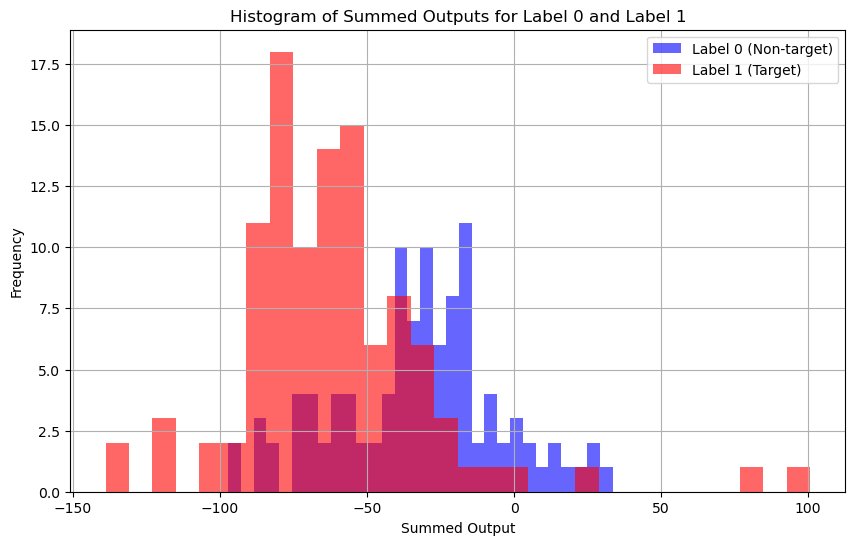

In [10]:
import matplotlib.pyplot as plt

# Separate summed outputs by label
summed_outputs_0 = all_summed_outputs[all_labels == 0]
summed_outputs_1 = all_summed_outputs[all_labels == 1]

# Plot histograms of summed outputs for both classes
plt.figure(figsize=(10, 6))
plt.hist(summed_outputs_0, bins=30, alpha=0.6, label='Label 0 (Non-target)', color='blue')
plt.hist(summed_outputs_1, bins=30, alpha=0.6, label='Label 1 (Target)', color='red')
plt.xlabel('Summed Output')
plt.ylabel('Frequency')
plt.title('Histogram of Summed Outputs for Label 0 and Label 1')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


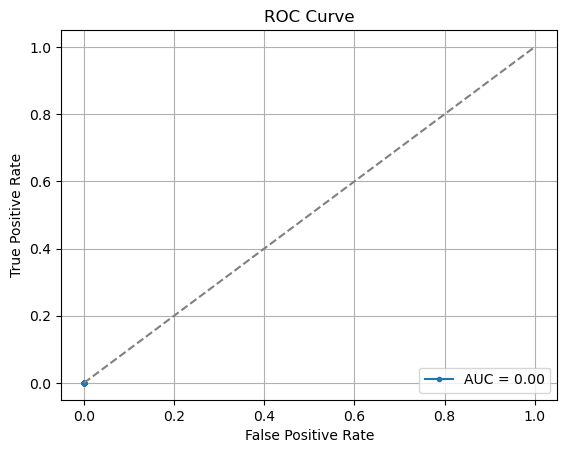

AUC: 0.00


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

threshold_vals = np.arange(-100., 100., 5.0)

# Function to plot the ROC curve and calculate AUC 
def plot_roc_curve(model, test_loader, threshold_vals):
    TPRs = [] 
    FPRs = []  

    model.output = 'spike'

    for th in threshold_vals:
        model.seq[-1].threshold = torch.tensor(th, dtype=torch.float32).to(device)
        
        true_positive = 0
        false_positive = 0
        true_negative = 0
        false_negative = 0

        for inputs, labels in test_loader:
            inputs = inputs.permute(0, 2, 1).to(device)
            labels = labels.to(device)

            outputs, _, _ = model(inputs, record=True)
            outputs_sum = outputs.sum(dim=1).detach().cpu().numpy()  

            # Binary prediction based on summed spiking activity
            predictions = (outputs_sum > 0).astype(int)
            
            true_positive += ((predictions == 1) & (labels.cpu().numpy() == 1)).sum()
            false_positive += ((predictions == 1) & (labels.cpu().numpy() == 0)).sum()
            true_negative += ((predictions == 0) & (labels.cpu().numpy() == 0)).sum()
            false_negative += ((predictions == 0) & (labels.cpu().numpy() == 1)).sum()

        # Calculate TPR and FPR for the current threshold
        TPR = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
        FPR = false_positive / (false_positive + true_negative) if (false_positive + true_negative) > 0 else 0.0
        
        TPRs.append(TPR)
        FPRs.append(FPR)

    auc_value = auc(FPRs, TPRs)

    # Plot ROC Curve
    plt.figure()
    plt.plot(FPRs, TPRs, marker='.', label=f'AUC = {auc_value:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    return TPRs, FPRs, auc_value

# Compute and plot the ROC curve
TPRs, FPRs, auc_value = plot_roc_curve(model, test_loader, threshold_vals)
print(f"AUC: {auc_value:.2f}")

NaN detected in raw model outputs
NaN detected in raw model outputs
NaN detected in raw model outputs
NaN detected in raw model outputs
NaN detected in raw model outputs
NaN detected in raw model outputs
NaN detected in raw model outputs
Number of NaNs in all_summed_outputs: 0


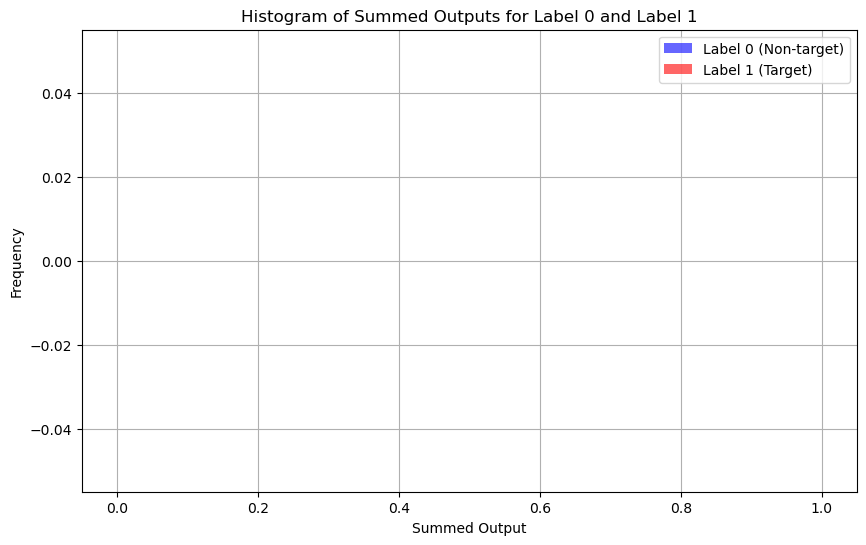

In [12]:
import numpy as np
import matplotlib.pyplot as plt

all_summed_outputs = []
all_labels = []

for inputs, labels in test_loader:
    inputs = inputs.permute(0, 2, 1).to(device)
    labels = labels.to(device)

    outputs, _, _ = model(inputs, record=True)

    # Check for NaNs in the outputs before summing
    if torch.isnan(outputs).any():
        print("NaN detected in raw model outputs")
        continue

    # Sum the outputs over the time dimension
    outputs_sum = outputs.sum(dim=1).detach().cpu().numpy()

    # Check for NaNs after summing
    if np.isnan(outputs_sum).any():
        print("NaN detected in summed outputs")
        continue

    all_summed_outputs.extend(outputs_sum.flatten())
    all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays 
all_summed_outputs = np.array(all_summed_outputs)
all_labels = np.array(all_labels)

# Check for NaNs
nan_count = np.isnan(all_summed_outputs).sum()
print(f"Number of NaNs in all_summed_outputs: {nan_count}")

# Filter Nans
all_summed_outputs = all_summed_outputs[~np.isnan(all_summed_outputs)]
all_labels = all_labels[~np.isnan(all_summed_outputs)]

summed_outputs_0 = all_summed_outputs[all_labels == 0]
summed_outputs_1 = all_summed_outputs[all_labels == 1]

# Plot histograms of summed outputs for both classes
plt.figure(figsize=(10, 6))
plt.hist(summed_outputs_0, bins=30, alpha=0.6, label='Label 0 (Non-target)', color='blue')
plt.hist(summed_outputs_1, bins=30, alpha=0.6, label='Label 1 (Target)', color='red')
plt.xlabel('Summed Output')
plt.ylabel('Frequency')
plt.title('Histogram of Summed Outputs for Label 0 and Label 1')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [13]:
import pickle
import numpy as np

with open('drawn_wood_results/drawn-wood-42-1.pkl', 'rb') as f:
    model_data = pickle.load(f)

membrane_potentials = model_data['membrane_potentials']
spike_outputs = model_data['spike_outputs']
synaptic_currents = model_data['synaptic_currents']

def check_for_nans(data_list, name):
    for i, data in enumerate(data_list):
        if np.isnan(data).any():
            print(f"NaN detected in {name} at index {i}")
            break

# Check each stored variable for NaNs
check_for_nans(membrane_potentials, 'membrane_potentials')
check_for_nans(spike_outputs, 'spike_outputs')
check_for_nans(synaptic_currents, 'synaptic_currents')

print(f"Sample membrane potentials: {membrane_potentials[:2]}")
print(f"Sample spike outputs: {spike_outputs[:2]}")
print(f"Sample synaptic currents: {synaptic_currents[:2]}")


Sample membrane potentials: [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)]
Sample spike outputs: [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)]
Sample synaptic currents: [array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
